<a href="https://colab.research.google.com/github/chaitragopalappa/MIE590-690D/blob/main/8c_Lab_LLM_NER_RE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

A simple model to demostrate knowlegdge graph extraction from unstrutured text data. For simpliity it reads one research abstract and does NER and RE tasks to create a knowledge graph.
1. named entirty recogniton (NER)
  - identifies and categorizes key information from text
  - use [BLURB:pretrained BioMedBERT but not fine-tuned for NER](https://microsoft.github.io/BLURB/models.html)  -equivalent of BERT finetuned on PubMed abstract and full text
  - use a model [fine-tuned for NER](https://github.com/librairy/bio-ner?tab=readme-ov-file)
2. relation extraction (RE)
  - RE automatically identifies and categorizes relationships between entities (like people, organizations, or places) in unstructured text, converting them into a structured format like a knowledge graph.
  - using model pretrained on PubMed domain [fine-tined for RE trained to identify 128 relations](https://pmc.ncbi.nlm.nih.gov/articles/PMC10551783/)
  - see [relation names here](https://huggingface.co/zhangzeyu/CT-PubMedBERT-RE-fine-tuned-group)
  - note this does not necessarily include the relations we are interested in. Using it for demostration


In [13]:
import re
import json
import itertools
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForTokenClassification,
    AutoModelForSequenceClassification,
    pipeline,
)

# =====================================================
# 1. LOAD ABSTRACT (technicaly we will be feeding many journal articles; here using one abstract for demostartion)
# =====================================================

abstract = """
Population-based studies have consistently shown that our diet has an influence on health.
Therefore, the aim of our study was to analyze differences between different dietary habit groups
in terms of health-related variables. The sample used for this cross-sectional study was taken
from the Austrian Health Interview Survey AT-HIS 2006/07. In a first step, subjects were matched
according to their age, sex, and socioeconomic status (SES). After matching, the total number of
subjects included in the analysis was 1320 (N = 330 for each form of diet – vegetarian,
carnivorous diet rich in fruits and vegetables, carnivorous diet less rich in meat, and
carnivorous diet rich in meat). Analyses of variance were conducted controlling for lifestyle
factors in the following domains: health (self-assessed health, impairment, number of chronic
conditions, vascular risk), health care (medical treatment, vaccinations, preventive check-ups),
and quality of life. In addition, differences concerning the presence of 18 chronic conditions
were analyzed by means of Chi-square tests. Overall, 76.4% of all subjects were female.
40.0% of the individuals were younger than 30 years, 35.4% between 30 and 49 years, and 24.0% older
than 50 years. 30.3% of the subjects had a low SES, 48.8% a middle one, and 20.9% had a high SES.
Our results revealed that a vegetarian diet is related to a lower BMI and less frequent alcohol
consumption. Moreover, our results showed that a vegetarian diet is associated with poorer health
(higher incidences of cancer, allergies, and mental health disorders), a higher need for health
care, and poorer quality of life. Therefore, public health programs are needed in order to reduce
the health risk due to nutritional factors.
"""



In [14]:

# =====================================================
# 2. BERT type MODEL SPECIFICALLY TRAINED ON BIOMEDICAL data for many differnt tasks including NER (BiomedBERT) https://microsoft.github.io/BLURB/models.html
# We need to fine-tune this for NER task, but lets review what words it extracts to compare with a model specifically trained for NER
# =====================================================

#model = "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract"
nlp_model = AutoModelForTokenClassification.from_pretrained("microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract-fulltext")
#nlp_model = AutoModelForTokenClassification.from_pretrained("bert-base-cased")
#tokenizer = AutoTokenizer.from_pretrained("microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract-fulltext")
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
nlp_pipe = pipeline("ner", model=nlp_model, tokenizer=tokenizer, aggregation_strategy="simple") #<-- test with different models for tokenizer and token classification

bio_entities = nlp_pipe(abstract)
print(bio_entities)

# Make sure each entity dict uses 'entity' (not 'word')
for e in bio_entities:
    if "word" in e:
        e["entity"] = e["word"]
        del e["word"]

print(bio_entities)
#print("Model config.id2label:")
#print(nlp_pipe.config.id2label)
print("Unique entity_group values from pipeline output:",
      sorted({e.get("entity_group") or e.get("entity") for e in bio_entities}))
# print a few example entities
for e in bio_entities[:20]:
    print(e)


Some weights of BertForTokenClassification were not initialized from the model checkpoint at microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract-fulltext and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cpu


[{'entity_group': 'LABEL_1', 'score': np.float32(0.5469591), 'word': 'Population - based studies have consistently shown that our diet has an influence on', 'start': 1, 'end': 83}, {'entity_group': 'LABEL_0', 'score': np.float32(0.5052187), 'word': 'health', 'start': 84, 'end': 90}, {'entity_group': 'LABEL_1', 'score': np.float32(0.5009572), 'word': '.', 'start': 90, 'end': 91}, {'entity_group': 'LABEL_0', 'score': np.float32(0.5080407), 'word': 'Therefore', 'start': 92, 'end': 101}, {'entity_group': 'LABEL_1', 'score': np.float32(0.51882434), 'word': ',', 'start': 101, 'end': 102}, {'entity_group': 'LABEL_0', 'score': np.float32(0.503321), 'word': 'the', 'start': 103, 'end': 106}, {'entity_group': 'LABEL_1', 'score': np.float32(0.51462865), 'word': 'aim of our study', 'start': 107, 'end': 123}, {'entity_group': 'LABEL_0', 'score': np.float32(0.5215659), 'word': 'was to', 'start': 124, 'end': 130}, {'entity_group': 'LABEL_1', 'score': np.float32(0.53868705), 'word': 'analyze difference

Notice above output gives only two labels. Also notice it give a warning "
Some weights of BertForTokenClassification were not initialized from the model checkpoint at microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract-fulltext and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference." The classfication head should be trained.

IOB (Inside-Outside-Beginning) tagging is a method for marking up text to identify named entities (NER) by assigning a specific label to each word. Each word is tagged as one of three types: "B" for the beginning of an entity, "I" for a word inside the same entity, and "O" for a word that is outside any entity.
Common named entities are 'PERSON', 'ORG', 'LOCATION".
IOB tag breakdown

    B (Beginning): This tag marks the first word of a named entity. For example, in the sentence "John Smith is here," "John" would be tagged as "B-Person".
    I (Inside): This tag marks any word that is part of the same entity but is not the first word. In the example, "Smith" would be tagged as "I-Person".
    O (Outside): This tag is used for any word that does not belong to a named entity. In the sentence "John Smith is here," "is" and "here" would be tagged as "O"

In [15]:
# named entities: we can specify the entities for our dataset and fine-tune - specifically retrain teh classifier head of a pretrained LLM.
# Note not fine-tuning here just giving an example of named entities we could fine-tune - we need a dataset for it.
#For datasets and open challenge see [BLURB:pretrained BioMedBERT but not fine-tuned for NER](https://microsoft.github.io/BLURB/models.html)
id2label = {0: "O", 1: "B-DISEASE", 2: "I-DISEASE", 3: "B-DIET", 4: "I-DIET", 5: "B-SES", 6: "I-SES"}
label2id = {"O": 0, "B-DISEASE": 1, "I-DISEASE": 2, "B-DIET": 3, "I-DIET": 4, "B-SES": 5, "I-SES": 6}
num_unique_labels = len(id2label)
print(num_unique_labels)
model_name = "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract"
nlp_multilabel_model = AutoModelForTokenClassification.from_pretrained(
    model_name,
    num_labels=num_unique_labels,
    id2label=id2label,
    label2id=label2id
)

tokenizer = AutoTokenizer.from_pretrained("microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract-fulltext")
#tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
nlp_pipe = pipeline("ner", model=nlp_multilabel_model, tokenizer=tokenizer, aggregation_strategy="simple") #<-- test with different models for tokenizer and token classification

bio_entities = nlp_pipe(abstract)
#print(bio_entities)

# Make sure each entity dict uses 'entity' (not 'word')
for e in bio_entities:
    if "word" in e:
        e["entity"] = e["word"]
        del e["word"]

print(bio_entities)
#print("Model config.id2label:")
#print(nlp_pipe.config.id2label)
print("Unique entity_group values from pipeline output:",
      sorted({e.get("entity_group") or e.get("entity") for e in bio_entities}))
# print a few example entities
for e in bio_entities[:20]:
    print(e)


7


Some weights of BertForTokenClassification were not initialized from the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cpu
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


[{'entity_group': 'SES', 'score': np.float32(0.26439792), 'start': 1, 'end': 11, 'entity': 'population'}, {'entity_group': 'SES', 'score': np.float32(0.24492125), 'start': 11, 'end': 12, 'entity': '-'}, {'entity_group': 'DISEASE', 'score': np.float32(0.25474212), 'start': 12, 'end': 25, 'entity': 'based studies'}, {'entity_group': 'SES', 'score': np.float32(0.2802413), 'start': 26, 'end': 30, 'entity': 'have'}, {'entity_group': 'DISEASE', 'score': np.float32(0.24211769), 'start': 31, 'end': 43, 'entity': 'consistently'}, {'entity_group': 'SES', 'score': np.float32(0.25404236), 'start': 44, 'end': 49, 'entity': 'shown'}, {'entity_group': 'SES', 'score': np.float32(0.27418202), 'start': 50, 'end': 54, 'entity': 'that'}, {'entity_group': 'DIET', 'score': np.float32(0.26130918), 'start': 55, 'end': 58, 'entity': 'our'}, {'entity_group': 'DISEASE', 'score': np.float32(0.23174118), 'start': 59, 'end': 63, 'entity': 'diet'}, {'entity_group': 'SES', 'score': np.float32(0.26027057), 'start': 64

Notice above results: we specified the classifier outout layers, but never trained it. So it randomly classifies.

In [16]:
# =====================================================
# 2. PRE-TRAINED FOR NER task - specifically named entity groups are 'Disease' (only one group)
# =====================================================
ner_model = AutoModelForTokenClassification.from_pretrained("alvaroalon2/biobert_diseases_ner")
tokenizer = AutoTokenizer.from_pretrained("alvaroalon2/biobert_diseases_ner")
#tokenizer = AutoTokenizer.from_pretrained("bert-base-cased") #<-- we can use different models for tokenizer v. token classificaion
ner_pipe = pipeline("ner", model=ner_model, tokenizer=tokenizer, aggregation_strategy="simple")
bio_entities=ner_pipe(abstract)
print(bio_entities)
# Make sure each entity dict uses 'entity' (not 'word')
for e in bio_entities:
    if "word" in e:
        e["entity"] = e["word"]
        del e["word"]

print("Model config.id2label:")
print(ner_model.config.id2label)
print("Unique entity_group values from pipeline output:",
      sorted({e.get("entity_group") or e.get("entity") for e in bio_entities}))
# print a few example entities
for e in bio_entities:
    print(e)

Device set to use cpu


[{'entity_group': '0', 'score': np.float32(0.9999229), 'word': 'Population - based studies have consistently shown that our diet has an influence on health. Therefore, the aim of our study was to analyze differences between different dietary habit groups in terms of health - related variables. The sample used for this cross - sectional study was taken from the Austrian Health Interview Survey AT - HIS 2006 / 07. In a first step, subjects were matched according to their age, sex, and socioeconomic status ( SES ). After matching, the total number of subjects included in the analysis was 1320 ( N = 330 for each form of diet – vegetarian, carnivorous diet rich in fruits and vegetables, carnivorous diet less rich in meat, and carnivorous diet rich in meat ). Analyses of variance were conducted controlling for lifestyle factors in the following domains : health ( self - assessed health, impairment, number of chronic conditions, vascular risk ), health care ( medical treatment, vaccinations, 

In [17]:
#model = AutoModelForTokenClassification.from_pretrained("dslim/bert-base-NER")
#tokenizer = AutoTokenizer.from_pretrained("dslim/bert-base-NER")
#nlp = pipeline("ner", model=model, tokenizer=tokenizer)
#print(nlp(abstract))

In [18]:
# Filter entity groups you care about (modify as needed)
VALID_BIO_TAGS = ["DISEASE"]# we can retain all relevant ones, the NER pre-trained model only has Disease, and 0 (other/none); we keep disease
 #['DISEASE', 'CHEMICAL', 'PROTEIN', 'CELL_LINE', 'CELL_TYPE'] #other exmples from NER trained on bio data

filtered_bio_entities = [
    e for e in bio_entities if e["entity_group"] in VALID_BIO_TAGS
]
print(filtered_bio_entities)

[{'entity_group': 'DISEASE', 'score': np.float32(0.99998605), 'start': 1537, 'end': 1543, 'entity': 'cancer'}, {'entity_group': 'DISEASE', 'score': np.float32(0.9817405), 'start': 1545, 'end': 1554, 'entity': 'allergies'}, {'entity_group': 'DISEASE', 'score': np.float32(0.999986), 'start': 1560, 'end': 1583, 'entity': 'mental health disorders'}]


In [25]:
# =====================================================
# 3. CUSTOM RULE-BASED SDH ENTITIES (AS ABOVE NER IS ONLY TRAINED FOR 'DISEASE')
# Custom rule-based named entities are a technique for extracting specific information from text using predefined rules, patterns, and dictionaries instead of machine learning. This method is highly customizable and easier to understand but requires manual creation and maintenance of rules as you can see below.
# =====================================================

sdh_entities = []
#synatx: "CATEGORY":[entity1, entity2]
#notice how we have explicitly set rules; if we have clearly defined and standard terminolgies this might work.
patterns = {
    "DIET_TYPE": [
        r"\bvegetarian diet\b",
        r"\bcarnivorous diet [^.,;)]*",
    ],
    "SES_LEVEL": [
        r"\blow SES\b",
        r"\bmiddle (?:one|SES)\b",
        r"\bhigh SES\b",
        #r"\bsocioeconomic status\b",
    ],

    "LIFESTYLE_FACTOR": [
        r"\balcohol consumption\b",
        r"\bmedical treatment\b",
        r"\bvaccinations\b",
        r"\bpreventive check-ups\b",
    ],
    "HEALTH_METRIC": [
        r"\blower BMI\b",
        r"\bquality of life\b",
    ]
}


for label, pats in patterns.items():
    for p in pats:
        for match in re.finditer(p, abstract, flags=re.I):
            sdh_entities.append({
                "entity": match.group(0),
                "entity_group": label,
                "start": match.start(),
                "end": match.end()
            })


In [20]:

# =====================================================
# 4. RELATION EXTRACTION
# =====================================================

# choose a model with biomedical RE
from transformers import AutoTokenizer, AutoModelForTokenClassification,AutoModelForSequenceClassification

re_model_name = "zhangzeyu/CT-PubMedBERT-RE-fine-tuned-noentity"   # <-- Change model here
re_tokenizer = AutoTokenizer.from_pretrained(re_model_name)
re_model = AutoModelForSequenceClassification.from_pretrained(re_model_name)
print("Model config.id2label:")
print(re_model.config.id2label)
# see relation names here https://huggingface.co/zhangzeyu/CT-PubMedBERT-RE-fine-tuned-group


Model config.id2label:
{0: 'LABEL_0', 1: 'LABEL_1', 2: 'LABEL_2', 3: 'LABEL_3', 4: 'LABEL_4', 5: 'LABEL_5', 6: 'LABEL_6', 7: 'LABEL_7', 8: 'LABEL_8', 9: 'LABEL_9', 10: 'LABEL_10', 11: 'LABEL_11', 12: 'LABEL_12', 13: 'LABEL_13', 14: 'LABEL_14', 15: 'LABEL_15', 16: 'LABEL_16', 17: 'LABEL_17', 18: 'LABEL_18', 19: 'LABEL_19', 20: 'LABEL_20', 21: 'LABEL_21', 22: 'LABEL_22', 23: 'LABEL_23', 24: 'LABEL_24', 25: 'LABEL_25', 26: 'LABEL_26', 27: 'LABEL_27', 28: 'LABEL_28', 29: 'LABEL_29', 30: 'LABEL_30', 31: 'LABEL_31', 32: 'LABEL_32', 33: 'LABEL_33', 34: 'LABEL_34', 35: 'LABEL_35', 36: 'LABEL_36', 37: 'LABEL_37', 38: 'LABEL_38', 39: 'LABEL_39', 40: 'LABEL_40', 41: 'LABEL_41', 42: 'LABEL_42', 43: 'LABEL_43', 44: 'LABEL_44', 45: 'LABEL_45', 46: 'LABEL_46', 47: 'LABEL_47', 48: 'LABEL_48', 49: 'LABEL_49', 50: 'LABEL_50', 51: 'LABEL_51', 52: 'LABEL_52', 53: 'LABEL_53', 54: 'LABEL_54', 55: 'LABEL_55', 56: 'LABEL_56', 57: 'LABEL_57', 58: 'LABEL_58', 59: 'LABEL_59', 60: 'LABEL_60', 61: 'LABEL_61', 62: 

In [21]:
# =====================================================
# 4b. PREPARE TOKENIZER / DEVICE
# =====================================================

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
re_model.to(device)
re_model.eval() #set model to evaluation / test state

# Add special entity markers to tokenizer (so they get their own tokens)
special_tokens = ["<e1>", "</e1>", "<e2>", "</e2>"]
re_tokenizer.add_special_tokens({"additional_special_tokens": special_tokens})
re_model.resize_token_embeddings(len(re_tokenizer))

# Ensure tokenizer has a pad token
if re_tokenizer.pad_token is None:
    # some tokenizers don't have pad_token; set to eos or unk
    if re_tokenizer.eos_token is not None:
        re_tokenizer.pad_token = re_tokenizer.eos_token
    else:
        re_tokenizer.pad_token = re_tokenizer.unk_token

id2label = getattr(re_model.config, "id2label", None)

# =====================================================
# 4c. BUILD CANDIDATE PAIRS
# =====================================================

# combine biomedical NER results and custom SDH entities
all_entities = filtered_bio_entities + sdh_entities



In [22]:
# Remove duplicate entities by start/end/text
def _uniq_entities(ents):
    seen = set()
    out = []
    for e in ents:
        #text = (e.get("entity") or e.get("word") or e.get("text") or "")
        #key = (e.get("start"), e.get("end"), re.sub(r"\s+", " ", text.strip()).lower(), e.get("entity_group"))
        key = (e["start"], e["end"], e["entity"].lower(), e.get("entity_group"))
        if key not in seen:
            seen.add(key)
            out.append(e)
    return out

all_entities = _uniq_entities(all_entities)
print(all_entities)

[{'entity_group': 'DISEASE', 'score': np.float32(0.99998605), 'start': 1537, 'end': 1543, 'entity': 'cancer'}, {'entity_group': 'DISEASE', 'score': np.float32(0.9817405), 'start': 1545, 'end': 1554, 'entity': 'allergies'}, {'entity_group': 'DISEASE', 'score': np.float32(0.999986), 'start': 1560, 'end': 1583, 'entity': 'mental health disorders'}, {'entity': 'vegetarian diet', 'entity_group': 'DIET_TYPE', 'start': 1349, 'end': 1364}, {'entity': 'vegetarian diet', 'entity_group': 'DIET_TYPE', 'start': 1466, 'end': 1481}, {'entity': 'carnivorous diet rich in fruits and vegetables', 'entity_group': 'DIET_TYPE', 'start': 567, 'end': 613}, {'entity': 'carnivorous diet less rich in meat', 'entity_group': 'DIET_TYPE', 'start': 615, 'end': 649}, {'entity': 'carnivorous diet rich in meat', 'entity_group': 'DIET_TYPE', 'start': 655, 'end': 684}, {'entity': 'low SES', 'entity_group': 'SES_LEVEL', 'start': 1266, 'end': 1273}, {'entity': 'middle one', 'entity_group': 'SES_LEVEL', 'start': 1283, 'end'

In [23]:
# sort by start index
all_entities = sorted(all_entities, key=lambda x: x["start"])

# Create candidate pairs (ordered by appearance). Skip overlapping.
pairs = []
for a, b in itertools.permutations(all_entities, 2):
    # only consider ordered pairs where a appears before b in text
    if a["start"] >= b["start"]:
        continue
    # skip if they overlap
    if a["end"] > b["start"]:
        continue
    pairs.append((a, b))

# optional: if too many pairs, limit them
MAX_PAIRS = 50
pairs = pairs[:MAX_PAIRS]

# =====================================================
# 4d. RELATION PREDICTION HELPER
# =====================================================

import torch.nn.functional as F

def mark_entities_and_tokenize(text, ent1, ent2, tokenizer, max_length=512):
    # ent1 and ent2 are dicts with 'start'/'end' indexes into text
    # we need to insert markers; mind that inserting one marker shifts indices for the other
    # we'll build string by slicing
    e1s, e1e = ent1["start"], ent1["end"]
    e2s, e2e = ent2["start"], ent2["end"]
    # ensure ent1 is before ent2
    if e1s > e2s:
        return mark_entities_and_tokenize(text, ent2, ent1, tokenizer, max_length)

    pre = text[:e1s]
    e1_text = text[e1s:e1e]
    middle = text[e1e:e2s]
    e2_text = text[e2s:e2e]
    post = text[e2e:]

    marked = pre + "<e1>" + e1_text + "</e1>" + middle + "<e2>" + e2_text + "</e2>" + post

    # tokenize
    encoded = tokenizer(
        marked,
        truncation=True,
        padding="longest",
        max_length=max_length,
        return_tensors="pt",
    )
    return encoded, marked

relations = []

for ent1, ent2 in pairs:
    try:
        encoded, marked_text = mark_entities_and_tokenize(abstract, ent1, ent2, re_tokenizer)
    except Exception as exc:
        # skip problematic pair
        continue

    encoded = {k: v.to(device) for k, v in encoded.items()}

    with torch.no_grad():
        outputs = re_model(**encoded)
        logits = outputs.logits  # shape (1, num_labels)
        probs = F.softmax(logits, dim=-1).squeeze(0).cpu().tolist()
        # pick top label
        top_idx = int(torch.argmax(logits, dim=-1).cpu().item())
        label = id2label[top_idx] if id2label is not None else str(top_idx)
        score = probs[top_idx]

    relations.append({
        "entity_1": {"text": ent1["entity"], "type": ent1.get("entity_group"), "start": ent1["start"], "end": ent1["end"]},
        "entity_2": {"text": ent2["entity"], "type": ent2.get("entity_group"), "start": ent2["start"], "end": ent2["end"]},
        "marked_sentence": marked_text,
        "predicted_label": label,
        "score": float(score),
        "all_scores": { (id2label[i] if id2label is not None else str(i)): float(p) for i,p in enumerate(probs) }
    })

# =====================================================
# 4e. FILTER & OUTPUT
# =====================================================

# filter out "no_relation" if it's in label space and optionally low-score relations
NOREL_LABELS = {"no_relation", "none", "NA", "no_relation\n"}
MIN_SCORE = 0.4

filtered_relations = []
for r in relations:
    lab_low = r["predicted_label"].lower()
    if lab_low in NOREL_LABELS and r["score"] < 0.5:
        continue
    if r["score"] < MIN_SCORE:
        continue
    filtered_relations.append(r)

result_dict = {
   "num_entities": len(all_entities),
   "num_candidate_pairs": len(pairs),
   "num_relations_predicted": len(relations),
   "num_relations_filtered": len(filtered_relations),
   "relations": filtered_relations
}
# print JSON summary
'''
print(json.dumps({
    "num_entities": len(all_entities),
    "num_candidate_pairs": len(pairs),
    "num_relations_predicted": len(relations),
    "num_relations_filtered": len(filtered_relations),
    "relations": filtered_relations
}, indent=2))
'''

'\nprint(json.dumps({\n    "num_entities": len(all_entities),\n    "num_candidate_pairs": len(pairs),\n    "num_relations_predicted": len(relations),\n    "num_relations_filtered": len(filtered_relations),\n    "relations": filtered_relations\n}, indent=2))\n'

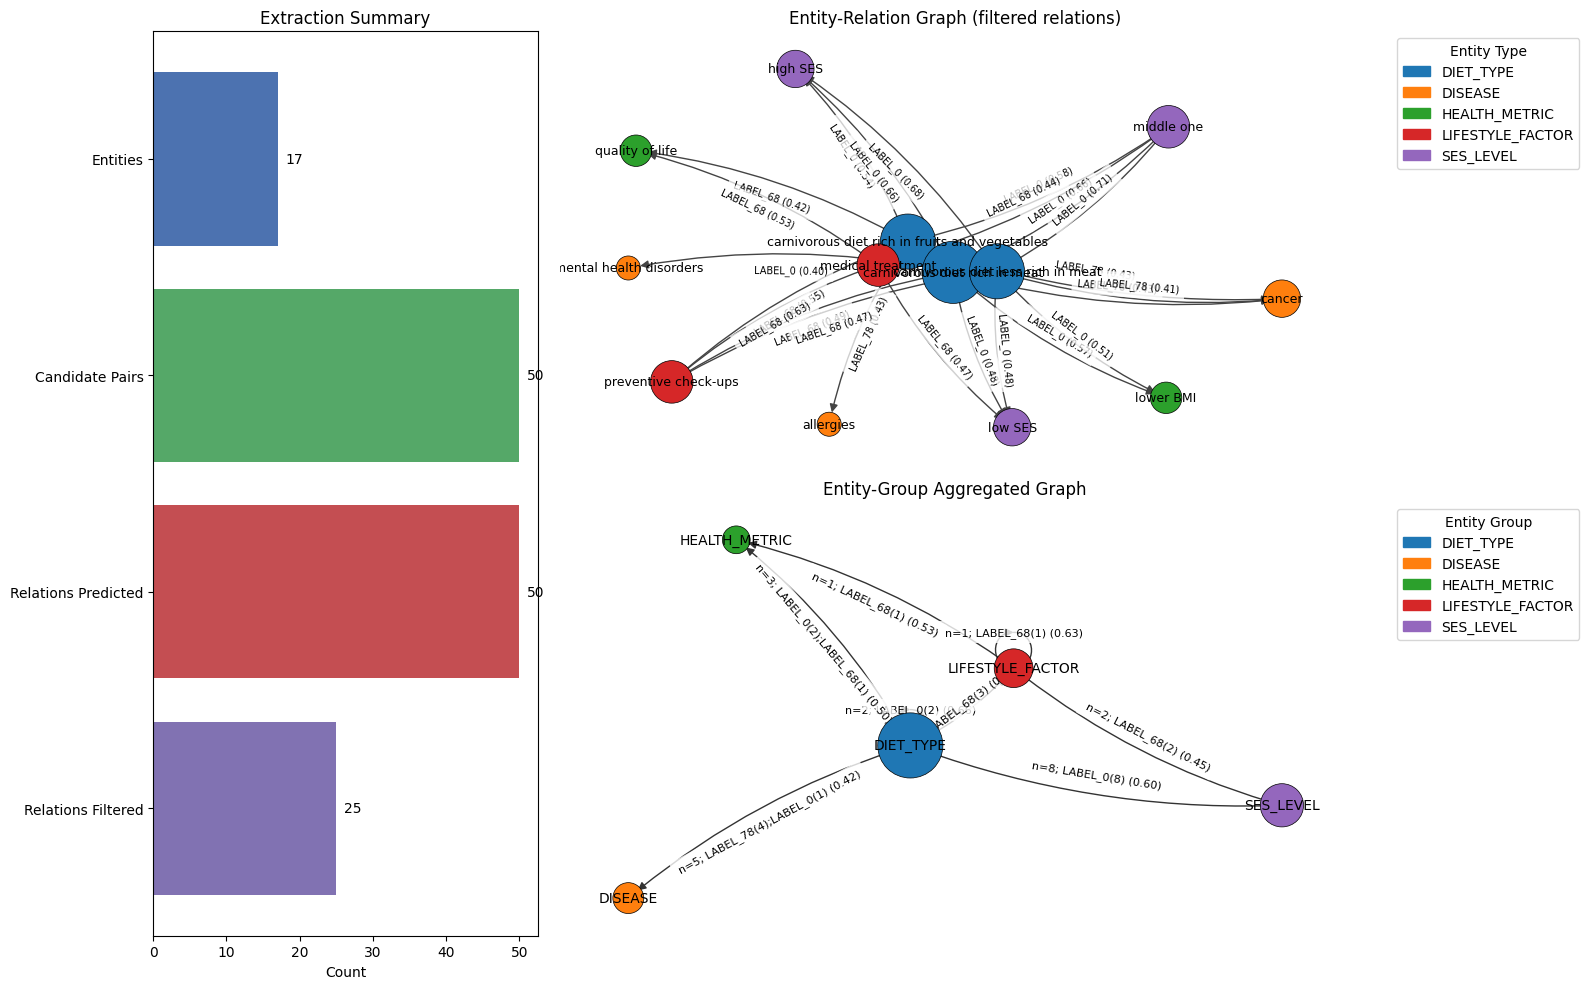


Relations (entity_1 -> entity_2 : label (score))
- carnivorous diet rich in fruits and vegetables -> preventive check-ups : LABEL_68 (0.55)
- carnivorous diet rich in fruits and vegetables -> quality of life : LABEL_68 (0.42)
- carnivorous diet rich in fruits and vegetables -> cancer : LABEL_78 (0.43)
- carnivorous diet rich in fruits and vegetables -> allergies : LABEL_78 (0.43)
- carnivorous diet less rich in meat -> preventive check-ups : LABEL_68 (0.47)
- carnivorous diet less rich in meat -> cancer : LABEL_78 (0.41)
- carnivorous diet rich in meat -> preventive check-ups : LABEL_68 (0.49)
- carnivorous diet rich in meat -> cancer : LABEL_78 (0.43)
- medical treatment -> preventive check-ups : LABEL_68 (0.63)
- medical treatment -> quality of life : LABEL_68 (0.53)
- medical treatment -> low SES : LABEL_68 (0.47)
- medical treatment -> middle one : LABEL_68 (0.44)


In [24]:
import json
import math
import matplotlib.pyplot as plt
import networkx as nx
from collections import Counter

def visualize_relations(output,
                        save_path="relations_viz.png",
                        figsize=(16, 10),
                        show=True,
                        plot_groups=False,
                        group_only=False):
    """
    Visualize relation extraction output.

    Args:
      output: dict or JSON string like:
        {
          "num_entities": ...,
          "num_candidate_pairs": ...,
          "num_relations_predicted": ...,
          "num_relations_filtered": ...,
          "relations": [ {entity_1:..., entity_2:..., predicted_label:..., score:..., ...}, ... ]
        }
      save_path: where to save the combined figure
      figsize: overall figure size
      show: whether to plt.show()
      plot_groups: whether to include an aggregated entity-group-only graph
      group_only: if True, only plot the group-level graph (and summary counts)
                 (overrides plotting the entity-level graph)
    Produces:
      - left: bar chart of counts
      - center/right: entity-level graph (unless group_only True)
      - bottom/right: entity-group aggregated graph (if plot_groups True)
    """
    # Accept either dict or JSON string
    if isinstance(output, str):
        data = json.loads(output)
    else:
        data = output

    counts = {
        "entities": data.get("num_entities", 0),
        "candidate_pairs": data.get("num_candidate_pairs", 0),
        "relations_predicted": data.get("num_relations_predicted", 0),
        "relations_filtered": data.get("num_relations_filtered", 0),
    }
    relations = data.get("relations", [])

    # Layout:
    # If plotting groups, create a 2x3 grid: left column (counts) spans both rows,
    # top-right: entity-level graph, bottom-right: group-level graph.
    # If not plotting groups, keep the original 1x3 layout (counts + wide graph).
    if plot_groups:
        fig = plt.figure(figsize=figsize)
        ax_counts = plt.subplot2grid((2, 3), (0, 0), rowspan=2, colspan=1)
        ax_entity = plt.subplot2grid((2, 3), (0, 1), colspan=2)
        ax_group = plt.subplot2grid((2, 3), (1, 1), colspan=2)
    else:
        fig = plt.figure(figsize=figsize)
        ax_counts = plt.subplot2grid((1, 3), (0, 0), colspan=1)
        ax_entity = plt.subplot2grid((1, 3), (0, 1), colspan=2)
        ax_group = None

    # ---------- Left: bar chart ----------
    keys = list(counts.keys())
    vals = [counts[k] for k in keys]
    bars = ax_counts.barh(range(len(keys)), vals, color=["#4c72b0", "#55a868", "#c44e52", "#8172b2"])
    ax_counts.set_yticks(range(len(keys)))
    ax_counts.set_yticklabels([k.replace("_", " ").title() for k in keys])
    ax_counts.invert_yaxis()
    ax_counts.set_xlabel("Count")
    ax_counts.set_title("Extraction Summary")
    for i, v in enumerate(vals):
        ax_counts.text(v + max(1, max(vals) * 0.01), i, str(v), va='center')

    # If no relations, show message in entity and group axes and finish
    if not relations:
        ax_entity.text(0.5, 0.5, "No filtered relations to display", ha="center", va="center")
        ax_entity.axis("off")
        if ax_group is not None:
            ax_group.text(0.5, 0.5, "No filtered relations to display", ha="center", va="center")
            ax_group.axis("off")
        plt.tight_layout()
        plt.savefig(save_path, dpi=200, bbox_inches="tight")
        if show:
            plt.show()
        plt.close(fig)
        return

    # ---------- Build entity-level graph ----------
    G = nx.DiGraph()
    node_types = {}
    mention_count = Counter()
    for r in relations:
        e1 = r["entity_1"]["text"]
        e2 = r["entity_2"]["text"]
        t1 = r["entity_1"].get("type", "UNK")
        t2 = r["entity_2"].get("type", "UNK")
        node_types[e1] = t1
        node_types[e2] = t2
        mention_count[e1] += 1
        mention_count[e2] += 1

        label = r.get("predicted_label", "")
        score = r.get("score", 0.0)
        edge_label = f"{label} ({score:.2f})"
        if G.has_edge(e1, e2):
            existing = G[e1][e2].get("labels", [])
            existing.append(edge_label)
            G[e1][e2]["labels"] = existing
        else:
            G.add_edge(e1, e2, labels=[edge_label], score=score, rel=label)

    # Node color mapping by type
    types = sorted(set(node_types.values()))
    palette = plt.get_cmap("tab10")
    color_map = {t: palette(i % 10) for i, t in enumerate(types)}

    # Node sizes scaled by mention_count
    min_sz = 300
    max_sz = 2000
    counts_vals = [mention_count[n] for n in G.nodes()]
    if counts_vals:
        max_c = max(counts_vals)
        min_c = min(counts_vals)
        node_sizes = []
        for c in counts_vals:
            if max_c == min_c:
                node_sizes.append((min_sz + max_sz) / 2)
            else:
                node_sizes.append(min_sz + (c - min_c) / (max_c - min_c) * (max_sz - min_sz))
    else:
        node_sizes = [600 for _ in G.nodes()]

    # Layout: spring layout for entity graph
    try:
        pos = nx.spring_layout(G, k=0.6, seed=42)
    except Exception:
        pos = nx.spring_layout(G, seed=42)

    # Draw entity-level graph unless group_only
    if not group_only:
        node_colors = [color_map.get(node_types[n], (0.7, 0.7, 0.7)) for n in G.nodes()]
        nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, ax=ax_entity, edgecolors="k", linewidths=0.5)
        nx.draw_networkx_labels(G, pos, font_size=9, ax=ax_entity)
        nx.draw_networkx_edges(G, pos, arrowstyle='-|>', arrowsize=12, connectionstyle='arc3,rad=0.1', edge_color="#444444", ax=ax_entity)

        edge_labels = {}
        for u, v, d in G.edges(data=True):
            joined = "; ".join(d.get("labels", []))
            if len(joined) > 40:
                joined = joined[:37] + "..."
            edge_labels[(u, v)] = joined

        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7, label_pos=0.5, ax=ax_entity, bbox=dict(facecolor="white", alpha=0.75, edgecolor="none"))
        ax_entity.set_title("Entity-Relation Graph (filtered relations)")
        ax_entity.axis("off")

        # Legend for types (entity-level)
        from matplotlib.patches import Patch
        handles = [Patch(color=color_map[t], label=t) for t in types]
        ax_entity.legend(handles=handles, title="Entity Type", bbox_to_anchor=(1.05, 1), loc="upper left")
    else:
        ax_entity.text(0.5, 0.5, "Entity-level graph hidden (group_only=True)", ha="center", va="center")
        ax_entity.axis("off")

    # ---------- Build and draw group-level (entity_group-only) graph ----------
    if plot_groups:
        # aggregate counts and edges by group
        mention_count_by_group = Counter()
        group_edges = {}  # (g1,g2) -> {count:int, labels:Counter, scores:[...]}
        for r in relations:
            g1 = r["entity_1"].get("type", "UNK")
            g2 = r["entity_2"].get("type", "UNK")
            mention_count_by_group[g1] += 1
            mention_count_by_group[g2] += 1
            key = (g1, g2)
            label = r.get("predicted_label", "")
            score = r.get("score", 0.0)
            if key not in group_edges:
                group_edges[key] = {"count": 0, "labels": Counter(), "scores": []}
            group_edges[key]["count"] += 1
            if label:
                group_edges[key]["labels"][label] += 1
            group_edges[key]["scores"].append(score)

        Gg = nx.DiGraph()
        for g in mention_count_by_group:
            Gg.add_node(g)
        for (g1, g2), info in group_edges.items():
            # pick top label(s)
            top_labels = [f"{lab}({cnt})" for lab, cnt in info["labels"].most_common(3)]
            avg_score = sum(info["scores"]) / len(info["scores"]) if info["scores"] else 0.0
            label_text = f"n={info['count']}; {';'.join(top_labels)} ({avg_score:.2f})"
            Gg.add_edge(g1, g2, count=info["count"], label=label_text)

        # colors and sizes for groups
        group_types = sorted(list(Gg.nodes()))
        palette2 = plt.get_cmap("tab10")
        group_color_map = {t: palette2(i % 10) for i, t in enumerate(group_types)}
        group_node_colors = [group_color_map.get(n, (0.7, 0.7, 0.7)) for n in Gg.nodes()]
        # size scaled by mention_count_by_group
        min_gsz = 400
        max_gsz = 2200
        g_counts_vals = [mention_count_by_group[n] for n in Gg.nodes()]
        if g_counts_vals:
            max_gc = max(g_counts_vals)
            min_gc = min(g_counts_vals)
            g_node_sizes = []
            for c in g_counts_vals:
                if max_gc == min_gc:
                    g_node_sizes.append((min_gsz + max_gsz) / 2)
                else:
                    g_node_sizes.append(min_gsz + (c - min_gc) / (max_gc - min_gc) * (max_gsz - min_gsz))
        else:
            g_node_sizes = [800 for _ in Gg.nodes()]

        try:
            posg = nx.spring_layout(Gg, k=0.6, seed=24)
        except Exception:
            posg = nx.spring_layout(Gg, seed=24)

        # Draw group graph
        nx.draw_networkx_nodes(Gg, posg, node_color=group_node_colors, node_size=g_node_sizes, ax=ax_group, edgecolors="k", linewidths=0.5)
        nx.draw_networkx_labels(Gg, posg, font_size=10, ax=ax_group)
        nx.draw_networkx_edges(Gg, posg, arrowstyle='-|>', arrowsize=12, connectionstyle='arc3,rad=0.1', edge_color="#333333", ax=ax_group)

        # Prepare and draw group edge labels
        edge_labels_g = {}
        for u, v, d in Gg.edges(data=True):
            txt = d.get("label", f"n={d.get('count', 0)}")
            if len(txt) > 60:
                txt = txt[:57] + "..."
            edge_labels_g[(u, v)] = txt
        nx.draw_networkx_edge_labels(Gg, posg, edge_labels=edge_labels_g, font_size=8, label_pos=0.5, ax=ax_group, bbox=dict(facecolor="white", alpha=0.8, edgecolor="none"))

        ax_group.set_title("Entity-Group Aggregated Graph")
        ax_group.axis("off")

        # Legend for groups
        from matplotlib.patches import Patch
        g_handles = [Patch(color=group_color_map[t], label=t) for t in group_types]
        ax_group.legend(handles=g_handles, title="Entity Group", bbox_to_anchor=(1.05, 1), loc="upper left")
    elif ax_group is not None:
        ax_group.text(0.5, 0.5, "Group graph not requested (plot_groups=False)", ha="center", va="center")
        ax_group.axis("off")

    plt.tight_layout()
    plt.savefig(save_path, dpi=200, bbox_inches="tight")
    if show:
        plt.show()
    plt.close(fig)

    # Also print a compact relation table to console for inspection
    if relations:
        print("\nRelations (entity_1 -> entity_2 : label (score))")
        for r in relations:
            e1 = r["entity_1"]["text"]
            e2 = r["entity_2"]["text"]
            label = r.get("predicted_label", "")
            score = r.get("score", 0.0)
            if label != "LABEL_0":
                print(f"- {e1} -> {e2} : {label} ({score:.2f})")
            #print(f"- {e1} -> {e2} : {label} ({score:.2f})")

# Example usage:
visualize_relations(result_dict, plot_groups=True)         # show both graphs
#visualize_relations(result_dict, plot_groups=True, group_only=True)  # show only group-level graph

Note: Above results are examples of the type of information of interest in casual inference from unstrutured text data (though model peform is a differnt question - open area of research).

abstract = """
Population-based studies have consistently shown that our diet has an influence on health.
Therefore, the aim of our study was to analyze differences between different dietary habit groups
in terms of health-related variables. The sample used for this cross-sectional study was taken
from the Austrian Health Interview Survey AT-HIS 2006/07. In a first step, subjects were matched
according to their age, sex, and socioeconomic status (SES). After matching, the total number of
subjects included in the analysis was 1320 (N = 330 for each form of diet – vegetarian,
carnivorous diet rich in fruits and vegetables, carnivorous diet less rich in meat, and
carnivorous diet rich in meat). Analyses of variance were conducted controlling for lifestyle
factors in the following domains: health (self-assessed health, impairment, number of chronic
conditions, vascular risk), health care (medical treatment, vaccinations, preventive check-ups),
and quality of life. In addition, differences concerning the presence of 18 chronic conditions
were analyzed by means of Chi-square tests. Overall, 76.4% of all subjects were female.
40.0% of the individuals were younger than 30 years, 35.4% between 30 and 49 years, and 24.0% older
than 50 years. 30.3% of the subjects had a low SES, 48.8% a middle one, and 20.9% had a high SES.
**Our results revealed that a vegetarian diet is related to a lower BMI and less frequent alcohol
consumption. Moreover, our results showed that a vegetarian diet is associated with poorer health
(higher incidences of cancer, allergies, and mental health disorders), a higher need for health
care, and poorer quality of life. Therefore, public health programs are needed in order to reduce
the health risk due to nutritional factors.**
"""